In [5]:
import numpy as np
from sklearn.datasets import make_moons
from scipy.spatial.distance import cosine
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
np.random.seed(42)

In [7]:
X,Y_ = make_moons(1000, noise=0.3)

In [8]:
Y = [[1,0] if y == 0 else [0,1] for y in Y_]

In [9]:
def categorical_cross_entropy(pred, y):
    return -np.mean(np.sum(y*np.log(pred), axis = 1))
def safe_softmax(z):
    z = z-np.max(z, axis=1, keepdims=True)
    z = np.exp(z)
    return z/np.sum(z, axis=1, keepdims=True)

In [10]:
class MLP:

    def __init__(self, input_size, hidden_size, output_size):

        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1,hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1,output_size))
        self.cache = {}
    def forward(self, X):
        self.cache['X'] = X # 1 x 2
        self.cache['Y1'] = X @ self.W1 + self.b1 # 1 x 4
        self.cache['A1'] = np.maximum(0, self.cache['Y1']) # 1 x 4
        self.cache['Y2'] = self.cache['A1'] @ self.W2 + self.b2 # 1 x 2
        return self.cache['Y2']
    
    def calc_loss_initial_grad(self, y2, y):
        
        preds = safe_softmax(y2)
        loss = categorical_cross_entropy(preds,y)

        dL_dy2 = preds - y

        return loss, dL_dy2

    
    def backprop(self, dL_dy2):
        batch_size = dL_dy2.shape[0]

        dL_dW2 = self.cache['A1'].T @ dL_dy2
        dL_db2 = np.sum(dL_dy2)

        dL_dA1 = dL_dy2 @ self.W2.T
        dL_dy1 = dL_dA1 * (self.cache['Y1'] > 0).astype(float)

        dL_dW1 = self.cache['X'].T @ dL_dy1
        dL_db1 = np.sum(dL_dy1)

        grad_without_jcob = {'dL_dW1':dL_dW1,'dL_dW2':dL_dW2,'dL_db1':dL_db1,'dL_db2':dL_db2, 'dL_dA1' : dL_dA1, 'dL_dy1':dL_dy1, 'dL_dy2': dL_dy2}
        return grad_without_jcob
        


In [ ]:
import abc
class ComputationNode(abc.ABC):
    
    def __init__(self):
        self.input = None
        self.output = None
        self.requires_grad = True
        self.grad_cache = {}
    def out_var_mean(self):
        try:
            return self.output.var(), self.output.mean()
        except self.output == None:
            return "Run the example through the layer"
    def in_var_mean(self):
        try:
            return self.input.var(), self.input.mean()
        except self.input == 0:
            return "Run the example through the layer"
    @abc.abstractmethod
    def forward(self, input):
        raise NotImplementedError
    @abc.abstractmethod
    def backward(self, output_grad):
        raise NotImplementedError
    
class Loss(abc.ABC):

    def __init__(self):
        self.input = None
        self.output = None
        self.grad_cache = {}
    @abc.abstractmethod
    def loss(self, pred, true):
        raise NotImplementedError
    @abc.abstractmethod
    def backward(self,output_grad):
        raise NotImplementedError
    
class Optimizer(abc.ABC):
    def __init__(self):
        self.params = None
        self.net = None
    @abc.abstractmethod
    def step(self):
        raise NotImplementedError
class Net:
    def __init__(self, layers):
        self.layers = layers
    def __seq(self,layers : list):
        self.layers = layers
    def forward(self, input):
        output = input
        for layer in self.layers:
            output = layer.forward(output)
        return output
    def backward(self,loss):
        grad = loss
        for layer in self.layers[::-1]:
            if isinstance(layer,ComputationNode) or isinstance(layer, Loss):
                grad = layer.backward(grad)
        return grad
    def print_variance_info(self):
        



In [ ]:
class Linear(ComputationNode):

    def __init__(self, input_size, output_size,initialization="None"):
        super().__init__()
        if initialization == "xavier":
            limit = np.sqrt(6 / (input_size + output_size))
            self.W = np.random.uniform(-limit, limit, (input_size, output_size))
        elif initialization == "he":
            std = np.sqrt(2 / input_size)
            self.W = np.random.randn(input_size, output_size) * std
        else:
            self.W = np.random.randn(input_size, output_size)
        self.b = np.zeros((1,output_size))

    def forward(self, input):
        self.input = input
        self.output = input @ self.W + self.b
        return self.output
    
    def backward(self, output_grad):
        self.grad_cache['dL_dW'] = self.input.T @ output_grad
        self.grad_cache['dL_dinput'] = output_grad @ self.W.T
        self.grad_cache['dL_db'] = np.sum(output_grad, axis=0, keepdims=True)  # FIXED
        return self.grad_cache['dL_dinput']
    def weights_var_mean(self):
        return self.W.var(), self.W.mean()
    def bias_var_mean(self):
        return self.b.var(), self.b.mean()
    
    def step(self, lr):
        self.W -= lr * self.grad_cache['dL_dW']
        self.b -= lr * self.grad_cache['dL_db']
    def plot_out(self):
        """Plots a heatmap of the output for the first sample in the batch."""
        output = self.output[0] if self.output.ndim == 3 else self.output  # Take first sample if batch exists
        plt.figure(figsize=(12, 5))
        sns.heatmap(output, cmap="coolwarm", annot=True, fmt=".2f")
        plt.title("Linear Layer Output Heatmap")
        plt.show()
        
class ReLU(ComputationNode):

    def __init__(self):
        super().__init__()
        self.requires_grad = False
    
    def forward(self,input):
        self.input = input
        self.output = np.maximum(0,input)
        return self.output
    
    def backward(self, output_grad):
        dL_dinput = output_grad * (self.input > 0).astype(float)
        self.grad_cache['dL_dinput'] = dL_dinput
        return self.grad_cache['dL_dinput']
    def plot_out(self):
        """Plots a heatmap of the output for the first sample in the batch."""
        output = self.output[0] if self.output.ndim == 3 else self.output  # Take first sample if batch exists
        plt.figure(figsize=(12, 5))
        sns.heatmap(output, cmap="coolwarm", annot=True, fmt=".2f")
        plt.title("Linear Layer Output Heatmap")
        plt.show()

class SoftMax(ComputationNode):

    def __init__(self):
        super().__init__()

    def forward(self, input):
        self.input = input
        inp_exp = np.exp(self.input - np.max(self.input, axis = 1, keepdims=True))
        denom = np.sum(inp_exp,axis = 1, keepdims=True)
        output = inp_exp/denom
        self.output = output
        return output
    
    def jacobian_softmax(self):
        
        batch_size, num_classes = self.input.shape
        jacobian = np.zeros((batch_size,num_classes,num_classes))
        for b in range(batch_size):
            for i in range(num_classes):
                s_i = self.output[b,i]
                for j in range(num_classes):
                    s_j = self.output[b,j]
                    if i == j:
                        jacobian[b, i, j] = s_i * (1 - s_j)
                    else:
                        jacobian[b, i, j] = -1 * s_i * s_j
        return jacobian
    
    def backward(self, output_grad):
        self.grad_cache['dS_dinput'] = self.jacobian_softmax()
        self.grad_cache['dL_dinput'] = np.einsum('bij,bj->bi', self.grad_cache['dS_dinput'], output_grad)
        return self.grad_cache['dL_dinput']
        
class CCE(Loss):

    def __init__(self):
        super().__init__()

    def loss(self, pred, true):
        self.input = (pred,np.array(true))
        loss = -np.mean(np.sum(true * np.log(pred),axis=1))
        self.output = loss
        return loss
    def backward(self):
        pred, true = self.input
        epsilon = 1e-9
        self.grad_cache['dL_dpred'] = -true / (pred + epsilon)
        return self.grad_cache['dL_dpred']


class SGD(Optimizer):
    def __init__(self, lr, net:Net):
        super().__init__()
        self.lr = lr
        self.net = net
    
    def step(self, ini_grad):
        self.net.backward(ini_grad)
        for layer in self.net.layers:
            if isinstance(layer,ComputationNode):
                if isinstance(layer, Linear) and layer.requires_grad:
                    layer.step(self.lr)
    



In [70]:
ne = [Linear(2,4),ReLU(), Linear(4,4),ReLU(),Linear(4,2),SoftMax()]
net = Net(ne)

In [71]:
criterion = CCE()
optimizer = SGD(0.0001,net)

In [72]:
for epoch in range(1000):
    out = net.forward(X)
    loss_ = criterion.loss(out,Y)
    print(f'loss -> {epoch} : {loss_}')
    ini_grad = criterion.backward()
    optimizer.step(ini_grad)

loss -> 0 : 1.210861845918266
loss -> 1 : 0.7196366582477717
loss -> 2 : 0.5708006290023386
loss -> 3 : 0.5459782358282751
loss -> 4 : 0.5328857386854257
loss -> 5 : 0.5207699872082262
loss -> 6 : 0.5090986721552696
loss -> 7 : 0.49800787920360723
loss -> 8 : 0.4876060357973423
loss -> 9 : 0.47801356017044616
loss -> 10 : 0.46927719453775396
loss -> 11 : 0.4610536225332382
loss -> 12 : 0.45322072241076977
loss -> 13 : 0.44609114396689004
loss -> 14 : 0.44013046906018477
loss -> 15 : 0.4352831988590772
loss -> 16 : 0.43100789121300753
loss -> 17 : 0.42710906621435935
loss -> 18 : 0.42382002471467967
loss -> 19 : 0.42085603265975297
loss -> 20 : 0.4183640351527988
loss -> 21 : 0.4161842296726612
loss -> 22 : 0.41415236661503035
loss -> 23 : 0.41221982030182963
loss -> 24 : 0.4104824563663897
loss -> 25 : 0.4088608878530982
loss -> 26 : 0.40733837567432374
loss -> 27 : 0.405930138377053
loss -> 28 : 0.40456914158263263
loss -> 29 : 0.4032810669285402
loss -> 30 : 0.4021023426960725
loss -

In [249]:
np.random.seed(32)

#ReLU
lin1 = Linear(2,50)
relu1 = ReLU()
lin2 = Linear(50,2)

#NonReLU
n_lin1 = Linear(2,50)
n_lin2 = Linear(50,2)

#HeInit
h_lin1 = Linear(2,50)
h_relu1 = ReLU()
h_lin2 = Linear(50,2)

#Direct MLP
mlp = MLP(2,50,2)

In [250]:
mlp.W1 = lin1.W
mlp.W2 = lin2.W
n_lin1.W = lin1.W
n_lin2.W = lin2.W

In [251]:
Sy_W1_grads = []
Jacobian_W1_grads = []
n_Jacobian_W1_grads = []
h_Jacobian_W1_grads = []
Sy_W2_grads = []
Jacobian_W2_grads = []
n_Jacobian_W2_grads = []
h_Jacobian_W2_grads = []


In [252]:
softmax = SoftMax()
crit = CCE()
lr = 0.0001

In [253]:
for epoch in range(3000):
    y = n_lin2.forward(n_lin1.forward(X))
    out = softmax.forward(y)
    loss_ = crit.loss(out,Y)
    print(f"epoch : {epoch} -> loss : {loss_}")
    dL_dX = n_lin1.backward(n_lin2.backward(softmax.backward(crit.backward())))
    n_Jacobian_W1_grads.append(n_lin1.grad_cache['dL_dW'].flatten())
    n_Jacobian_W2_grads.append(n_lin2.grad_cache['dL_dW'].flatten())
    n_lin1.step(lr)
    n_lin2.step(lr)

epoch : 0 -> loss : 3.309028305749015
epoch : 1 -> loss : 0.8966355182867424
epoch : 2 -> loss : 0.7577578242272925
epoch : 3 -> loss : 0.726448665085379
epoch : 4 -> loss : 0.6968903063851127
epoch : 5 -> loss : 0.6680246364180698
epoch : 6 -> loss : 0.6398653013910849
epoch : 7 -> loss : 0.6124321289848988
epoch : 8 -> loss : 0.5857575401088406
epoch : 9 -> loss : 0.5598933044242281
epoch : 10 -> loss : 0.5349126477200323
epoch : 11 -> loss : 0.5109105756047566
epoch : 12 -> loss : 0.4880034448715112
epoch : 13 -> loss : 0.4663278223084632
epoch : 14 -> loss : 0.446038041730202
epoch : 15 -> loss : 0.4273013849507652
epoch : 16 -> loss : 0.41028946055327
epoch : 17 -> loss : 0.39516431912433564
epoch : 18 -> loss : 0.38205851107892275
epoch : 19 -> loss : 0.37105014671680137
epoch : 20 -> loss : 0.3621372236101678
epoch : 21 -> loss : 0.3552191219773652
epoch : 22 -> loss : 0.35009469715865155
epoch : 23 -> loss : 0.346482769203805
epoch : 24 -> loss : 0.3440617518011512
epoch : 25 -

In [254]:
for epoch in range(3000):
    y = h_lin2.forward(h_relu1.forward(h_lin1.forward(X)))
    out = softmax.forward(y)
    loss_ = crit.loss(out,Y)
    print(f"epoch : {epoch} -> loss : {loss_}")
    dL_dX = h_lin1.backward(h_relu1.backward(h_lin2.backward(softmax.backward(crit.backward()))))
    h_Jacobian_W1_grads.append(h_lin1.grad_cache['dL_dW'].flatten())
    h_Jacobian_W2_grads.append(h_lin2.grad_cache['dL_dW'].flatten())
    h_lin1.step(lr)
    h_lin2.step(lr)

epoch : 0 -> loss : 6.941976308176686
epoch : 1 -> loss : 4.722216706587961
epoch : 2 -> loss : 2.5451360408384116
epoch : 3 -> loss : 1.3484502524051438
epoch : 4 -> loss : 1.0754156363689735
epoch : 5 -> loss : 0.9201691107882974
epoch : 6 -> loss : 0.8120908465267719
epoch : 7 -> loss : 0.7347978980876405
epoch : 8 -> loss : 0.6792329980959784
epoch : 9 -> loss : 0.6387875900526804
epoch : 10 -> loss : 0.6085945847105929
epoch : 11 -> loss : 0.5849181376482763
epoch : 12 -> loss : 0.5658031714055495
epoch : 13 -> loss : 0.5496379268907331
epoch : 14 -> loss : 0.5354248159272657
epoch : 15 -> loss : 0.5226220409425104
epoch : 16 -> loss : 0.5108691088014188
epoch : 17 -> loss : 0.49998153504498505
epoch : 18 -> loss : 0.48983736097752545
epoch : 19 -> loss : 0.4804847735695494
epoch : 20 -> loss : 0.47177175358100454
epoch : 21 -> loss : 0.46357901053513423
epoch : 22 -> loss : 0.4558747647352347
epoch : 23 -> loss : 0.44863820253241044
epoch : 24 -> loss : 0.44173760911298887
epoch 

In [255]:
for epoch in range(3000):
    y = lin2.forward(relu1.forward(lin1.forward(X)))
    out = softmax.forward(y)
    loss_ = crit.loss(out,Y)
    print(f"epoch : {epoch} -> loss : {loss_}")
    dL_dX = lin1.backward(relu1.backward(lin2.backward(softmax.backward(crit.backward()))))
    Jacobian_W1_grads.append(lin1.grad_cache['dL_dW'].flatten())
    Jacobian_W2_grads.append(lin2.grad_cache['dL_dW'].flatten())
    lin1.step(lr)
    lin2.step(lr)

epoch : 0 -> loss : 0.6371324917931165
epoch : 1 -> loss : 0.41951568482382495
epoch : 2 -> loss : 0.37470436430837856
epoch : 3 -> loss : 0.37115702670456063
epoch : 4 -> loss : 0.36847681879985555
epoch : 5 -> loss : 0.36624013336143774
epoch : 6 -> loss : 0.36429395854366503
epoch : 7 -> loss : 0.3625147611383184
epoch : 8 -> loss : 0.3608811817009788
epoch : 9 -> loss : 0.35937179764978966
epoch : 10 -> loss : 0.35793498990743644
epoch : 11 -> loss : 0.3565507334126346
epoch : 12 -> loss : 0.35521265977184857
epoch : 13 -> loss : 0.35394480834063385
epoch : 14 -> loss : 0.3527189071577764
epoch : 15 -> loss : 0.35154008491800626
epoch : 16 -> loss : 0.3503895954737042
epoch : 17 -> loss : 0.3492907704269115
epoch : 18 -> loss : 0.348232464340498
epoch : 19 -> loss : 0.34717140555027404
epoch : 20 -> loss : 0.3461350555164122
epoch : 21 -> loss : 0.3451411717773561
epoch : 22 -> loss : 0.3441741135136381
epoch : 23 -> loss : 0.34321247318678727
epoch : 24 -> loss : 0.342280224118479

In [256]:
epochs=3000
lr = 0.0001

In [257]:
for epoch in range(epochs):
    y_ = mlp.forward(X)
    loss, dL_dy2 = mlp.calc_loss_initial_grad(y_, Y)
    grads = mlp.backprop(dL_dy2)
    print(f"epoch {epoch} -> loss : {loss}")
    mlp.W1 = mlp.W1 - lr * grads['dL_dW1']
    mlp.b1 = mlp.b1 - lr * grads['dL_db1']
    mlp.W2 = mlp.W2 - lr * grads['dL_dW2']
    mlp.b2 = mlp.b2 - lr * grads['dL_db2']
    Sy_W1_grads.append(grads['dL_dW1'].flatten())
    Sy_W2_grads.append(grads['dL_dW2'].flatten())

epoch 0 -> loss : 0.8933850414648838
epoch 1 -> loss : 0.7359088262874518
epoch 2 -> loss : 0.6190805780555836
epoch 3 -> loss : 0.5319016844994892
epoch 4 -> loss : 0.468196109411559
epoch 5 -> loss : 0.4235366872529876
epoch 6 -> loss : 0.39478350718148525
epoch 7 -> loss : 0.3773875795189319
epoch 8 -> loss : 0.3658938271423265
epoch 9 -> loss : 0.357239093778434
epoch 10 -> loss : 0.35082088779605686
epoch 11 -> loss : 0.3463912855107681
epoch 12 -> loss : 0.3430596981034501
epoch 13 -> loss : 0.3404736016642436
epoch 14 -> loss : 0.33837313453354584
epoch 15 -> loss : 0.3365847836557606
epoch 16 -> loss : 0.3350593657576252
epoch 17 -> loss : 0.3337608880511924
epoch 18 -> loss : 0.33264121594704804
epoch 19 -> loss : 0.33160857969679364
epoch 20 -> loss : 0.3306632602241016
epoch 21 -> loss : 0.3298238845307828
epoch 22 -> loss : 0.3290729891372605
epoch 23 -> loss : 0.32832051322207273
epoch 24 -> loss : 0.32757093285265626
epoch 25 -> loss : 0.32695176028248135
epoch 26 -> loss

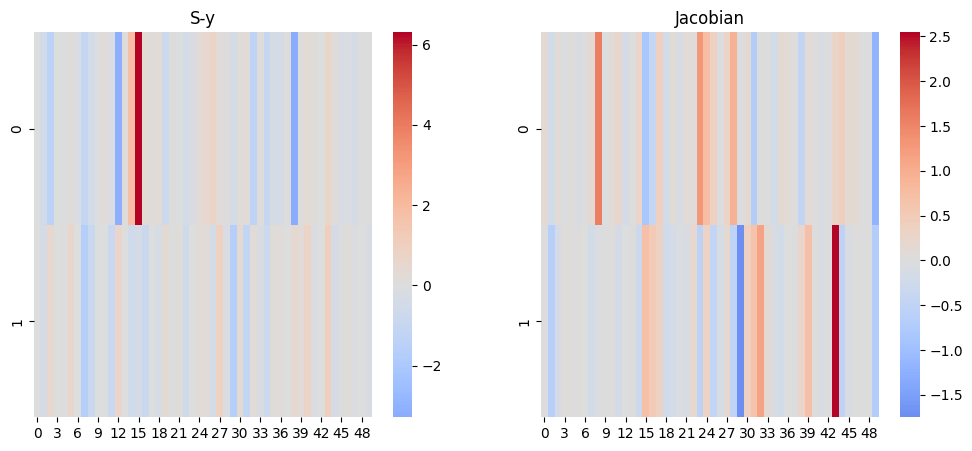

In [258]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(grads['dL_dW1'], cmap="coolwarm", center=0)
plt.title("S-y")

plt.subplot(1, 2, 2)
sns.heatmap(lin1.grad_cache['dL_dW'], cmap="coolwarm", center=0)
plt.title("Jacobian")

plt.show()

In [218]:
from scipy.spatial.distance import cosine

In [219]:
1 - cosine(grads['dL_dW1'].flatten() , n_lin1.grad_cache['dL_dW'].flatten()).item()

0.06422895121587147

In [259]:
def plot_gradient_norms(sy_grads, jacobian_grads,n_jacobian_grads, h_jacobian_grads, epochs):
    """Plots gradient norm differences over epochs."""
    sy_norms = [torch.norm(torch.tensor(g)).item() for g in sy_grads]
    jacobian_norms = [torch.norm(torch.tensor(g)).item() for g in jacobian_grads]
    n_jacobian_norms = [torch.norm(torch.tensor(g)).item() for g in n_jacobian_grads]
    h_jacobian_norms = [torch.norm(torch.tensor(g)).item() for g in h_jacobian_grads]
    epochs = [i for i in range(1,epochs+1)]
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, sy_norms, label='S-y Grad Norm', color='b')
    plt.plot(epochs, jacobian_norms, label='Jacobian Grad Norm', color='r')
    plt.plot(epochs, n_jacobian_norms, label='N Jacobian Grad Norm', color='g')
    plt.plot(epochs, h_jacobian_norms, label='H Jacobian Grad Norm', color='k')
    plt.xlabel('Epochs')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.title('Gradient Norms Over Epochs')
    plt.grid()
    plt.show()


def plot_loss_landscape(W1, loss_fn, w_range=(-0.2, 0.2), resolution=50):
    """Plots loss landscape around W1."""
    W1_flat = W1.clone().detach().flatten()
    d1, d2 = np.random.randn(*W1_flat.shape), np.random.randn(*W1_flat.shape)
    d1 /= np.linalg.norm(d1)
    d2 /= np.linalg.norm(d2)
    
    alphas = np.linspace(w_range[0], w_range[1], resolution)
    betas = np.linspace(w_range[0], w_range[1], resolution)
    losses = np.zeros((resolution, resolution))
    
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            W_test = W1_flat + alpha * torch.tensor(d1) + beta * torch.tensor(d2)
            W_test = W_test.view(W1.shape)
            losses[i, j] = loss_fn(W_test).item()
    
    X, Y = np.meshgrid(alphas, betas)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, losses, cmap='viridis')
    ax.set_xlabel('Direction 1')
    ax.set_ylabel('Direction 2')
    ax.set_zlabel('Loss')
    ax.set_title('Loss Landscape Around W1')
    plt.show()


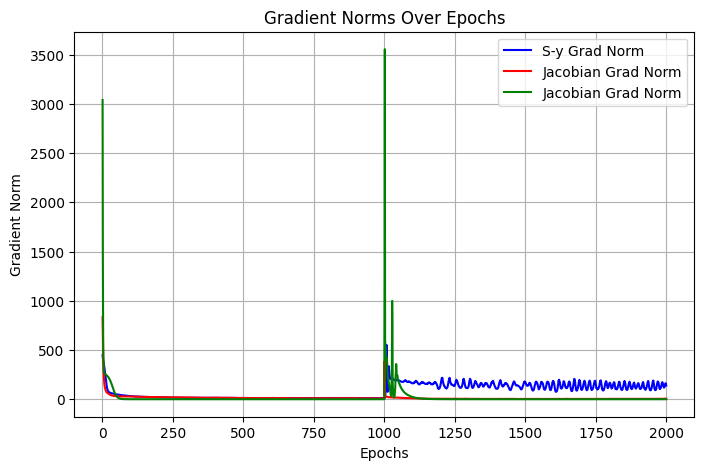

In [135]:
plot_gradient_norms(Sy_W1_grads, Jacobian_W1_grads,n_Jacobian_W1_grads, 2000)

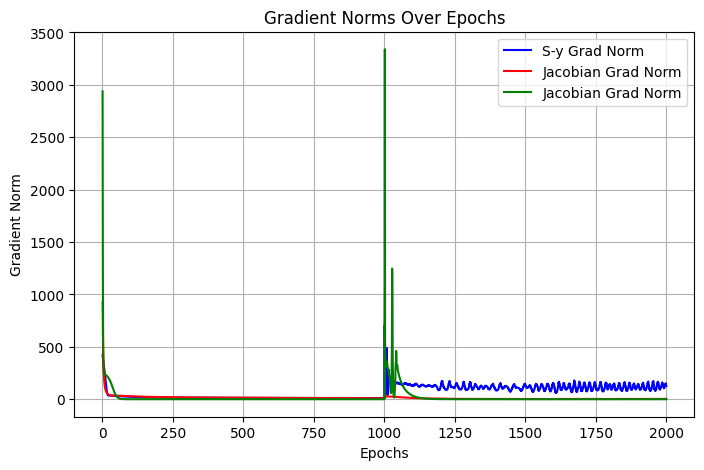

In [136]:
plot_gradient_norms(Sy_W2_grads, Jacobian_W2_grads,n_Jacobian_W2_grads, 2000)

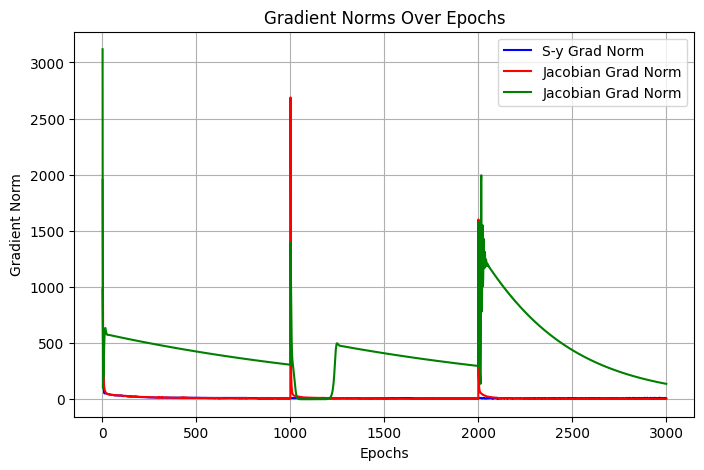

In [163]:
plot_gradient_norms(Sy_W1_grads, Jacobian_W1_grads,n_Jacobian_W1_grads, 3000)

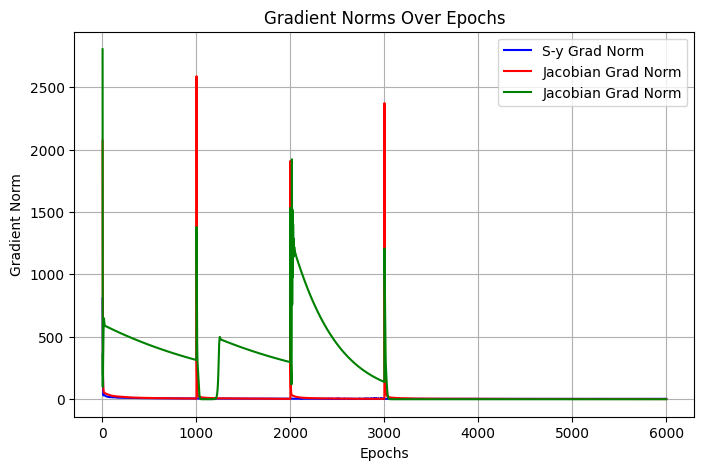

In [172]:
plot_gradient_norms(Sy_W2_grads, Jacobian_W2_grads,n_Jacobian_W2_grads, 6000)

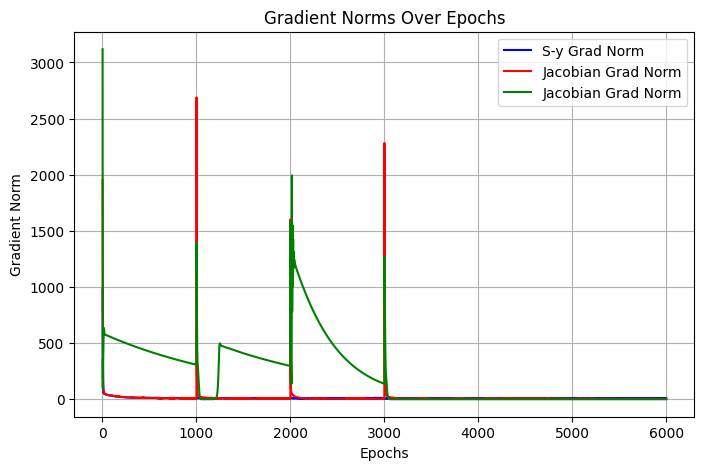

In [173]:
plot_gradient_norms(Sy_W1_grads, Jacobian_W1_grads,n_Jacobian_W1_grads, 6000)

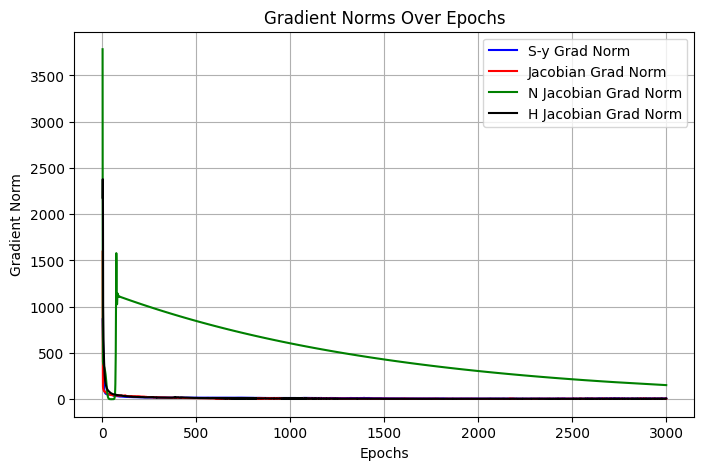

In [260]:
plot_gradient_norms(Sy_W1_grads, Jacobian_W1_grads,n_Jacobian_W1_grads, h_Jacobian_W1_grads, 3000)

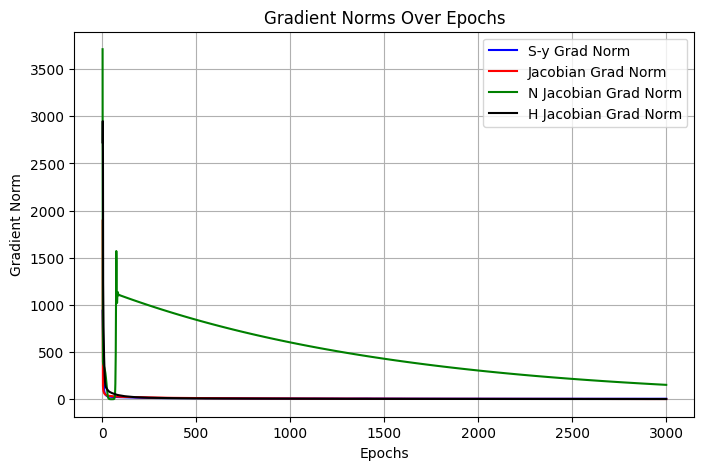

In [261]:
plot_gradient_norms(Sy_W2_grads, Jacobian_W2_grads,n_Jacobian_W2_grads, h_Jacobian_W2_grads, 3000)

In [193]:
X[0]

array([-0.17186341,  0.59624885])

In [221]:
Y_[:10], Y[:10]

(array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int64),
 [[0, 1],
  [1, 0],
  [0, 1],
  [0, 1],
  [1, 0],
  [1, 0],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1]])

In [230]:
y = n_lin2.forward(n_lin1.forward(np.expand_dims(X[2],axis=0)))

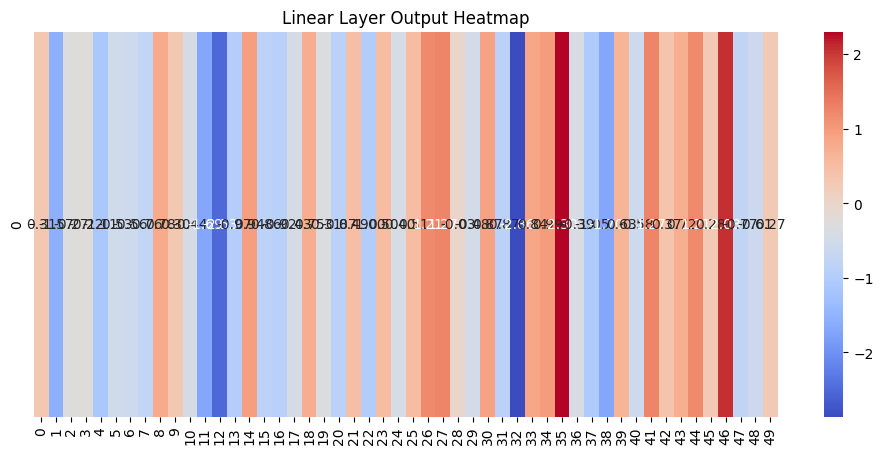

In [227]:
n_lin1.plot_out()

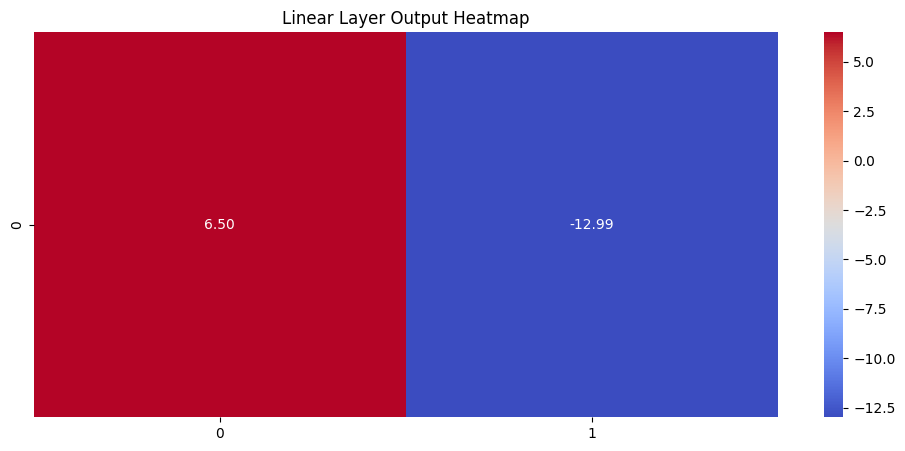

In [228]:
n_lin2.plot_out()

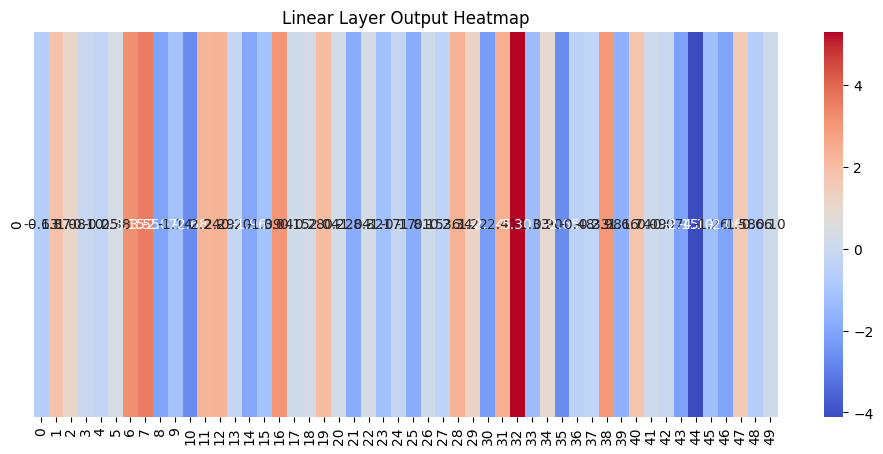

In [231]:
n_lin1.plot_out()

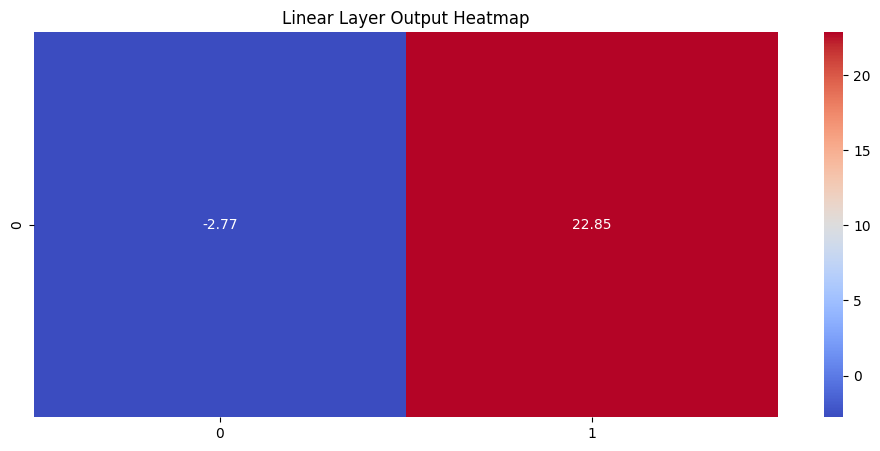

In [232]:
n_lin2.plot_out()

In [233]:
safe_softmax(y)

array([[7.45631641e-12, 1.00000000e+00]])

In [234]:
y = lin2.forward(relu1.forward(lin1.forward(np.expand_dims(X[1],axis=0))))

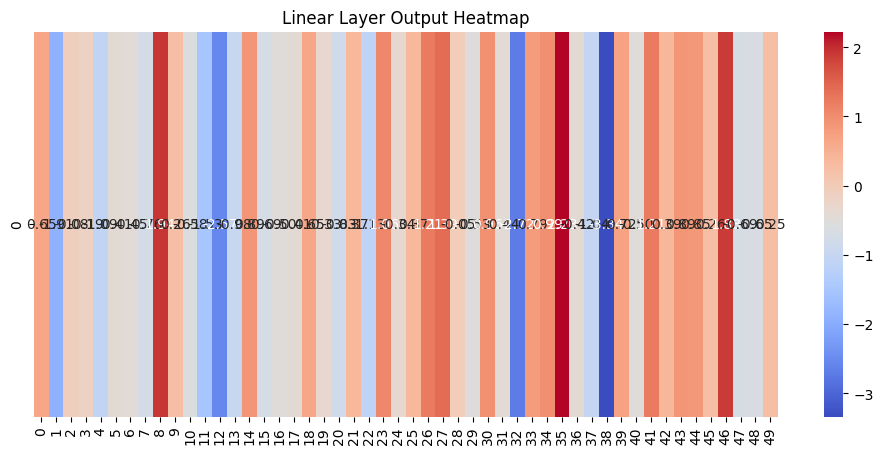

In [235]:
lin1.plot_out()

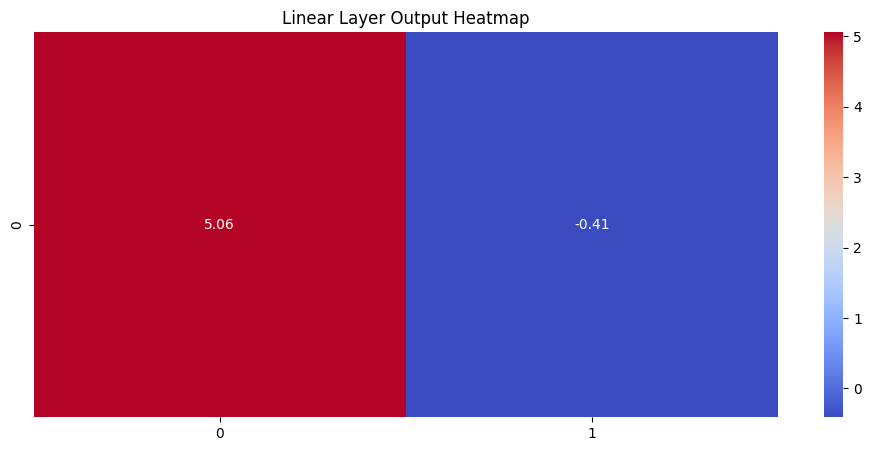

In [237]:
lin2.plot_out()

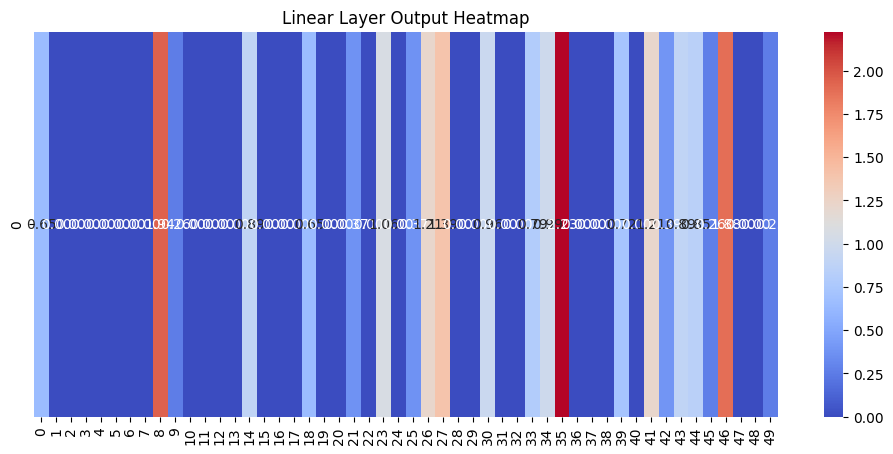

In [238]:
relu1.plot_out()

In [242]:
y = lin2.forward(relu1.forward(lin1.forward(np.expand_dims(X[3],axis=0))))

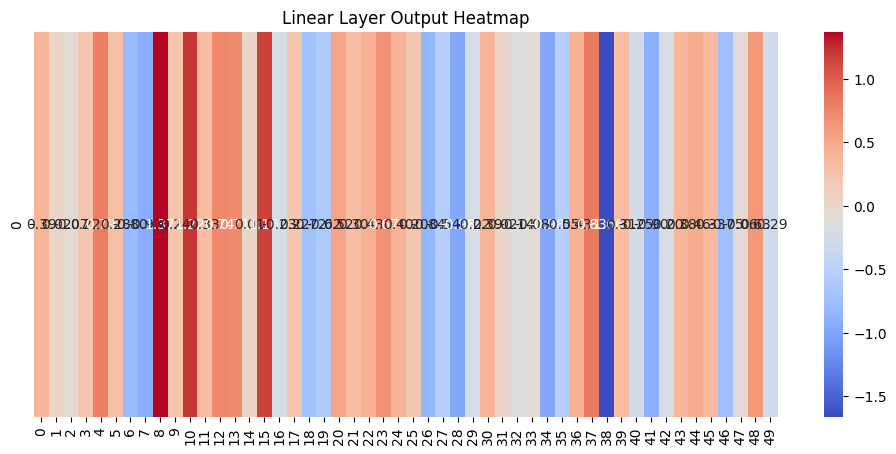

In [243]:
lin1.plot_out()

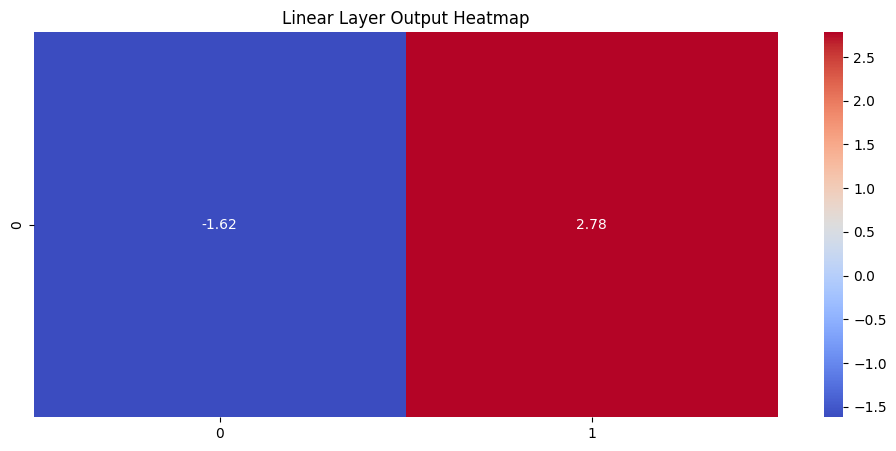

In [244]:
lin2.plot_out()

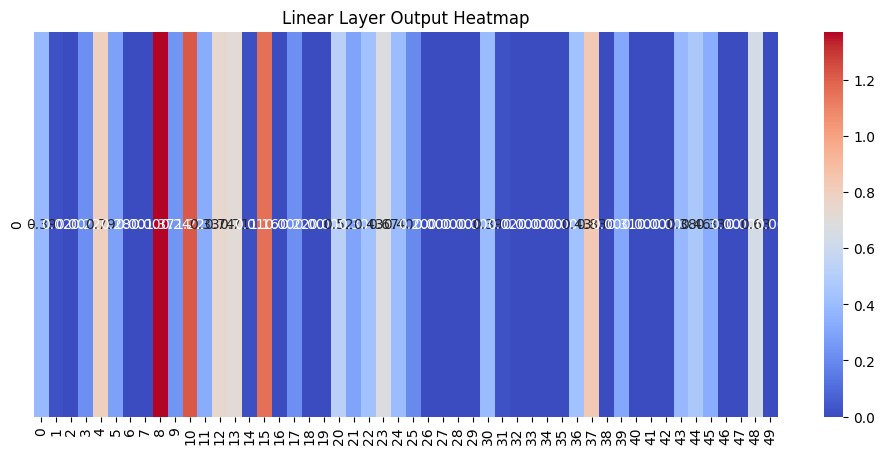

In [245]:
relu1.plot_out()

In [270]:
y = h_lin2.forward(h_relu1.forward(h_lin1.forward(np.expand_dims(X[3],axis=0))))


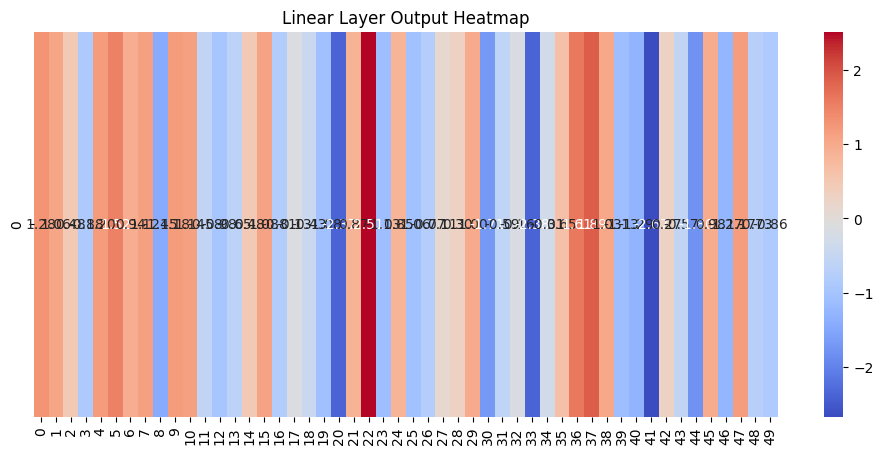

In [263]:
h_lin1.plot_out()

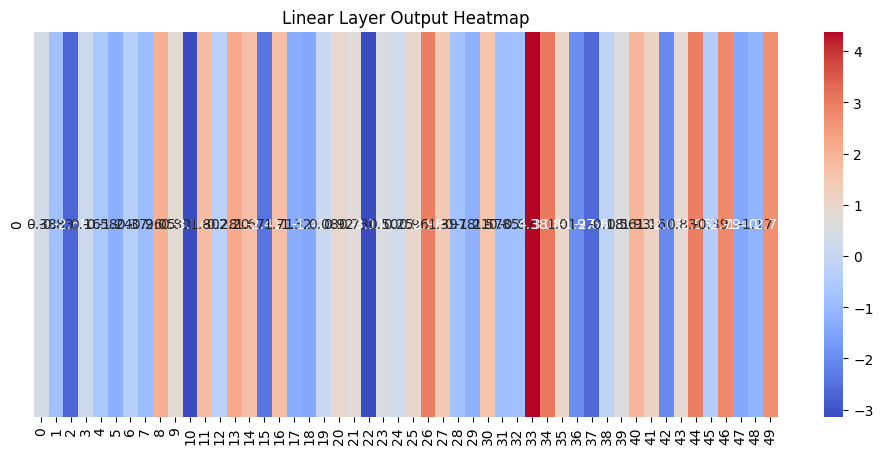

In [267]:
h_lin1.plot_out()

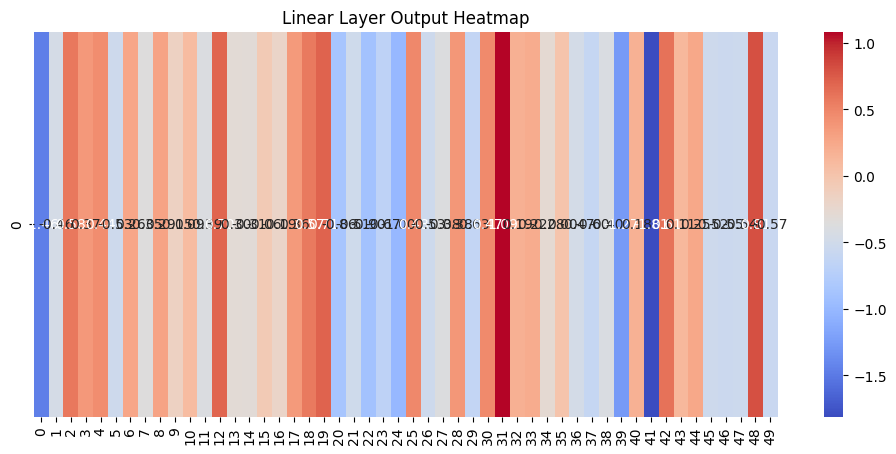

In [271]:
h_lin1.plot_out()

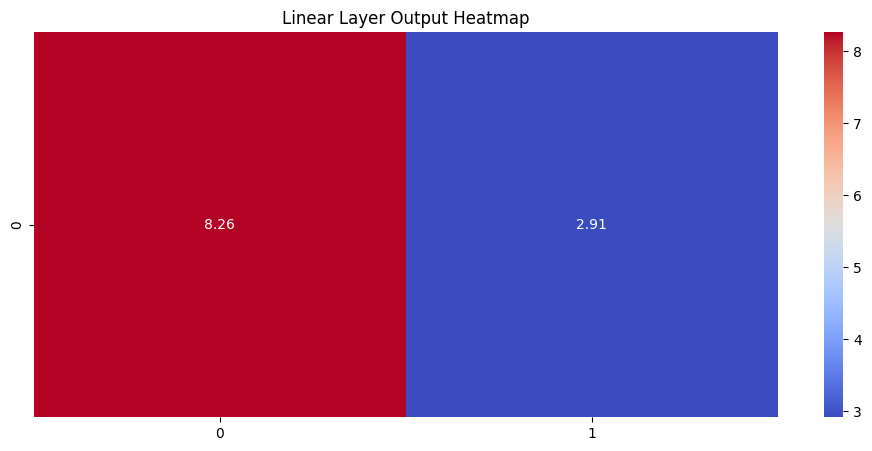

In [264]:
h_lin2.plot_out()

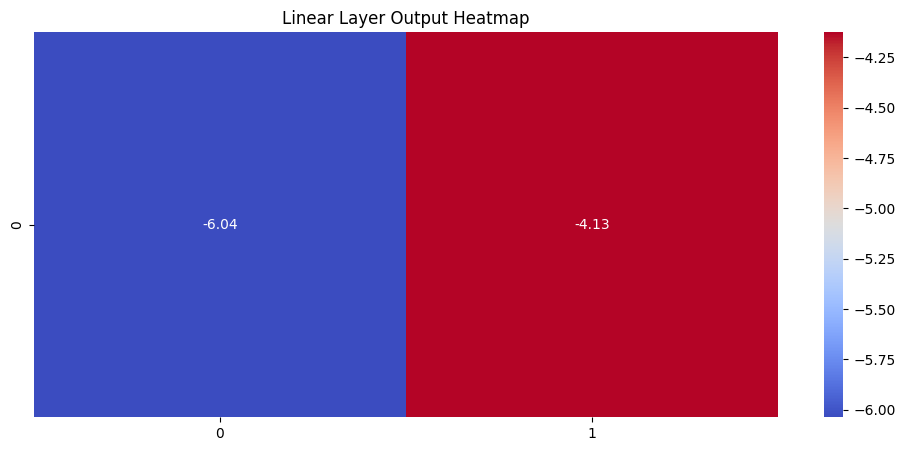

In [268]:
h_lin2.plot_out()

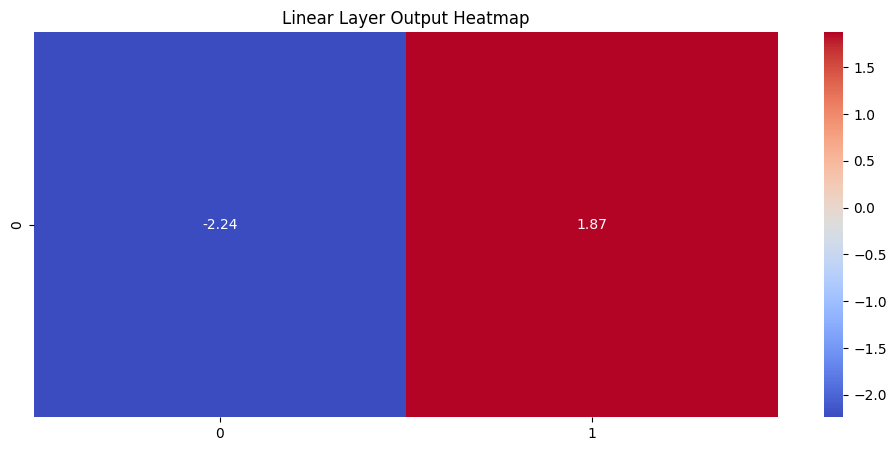

In [272]:
h_lin2.plot_out()

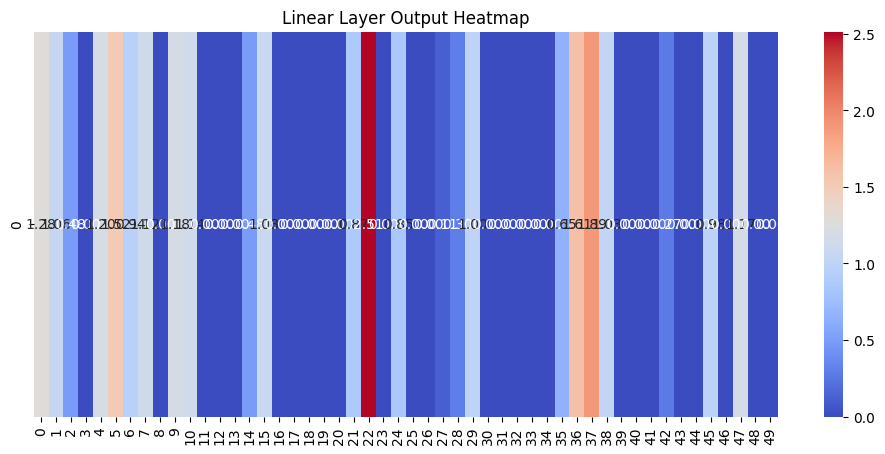

In [265]:
h_relu1.plot_out()

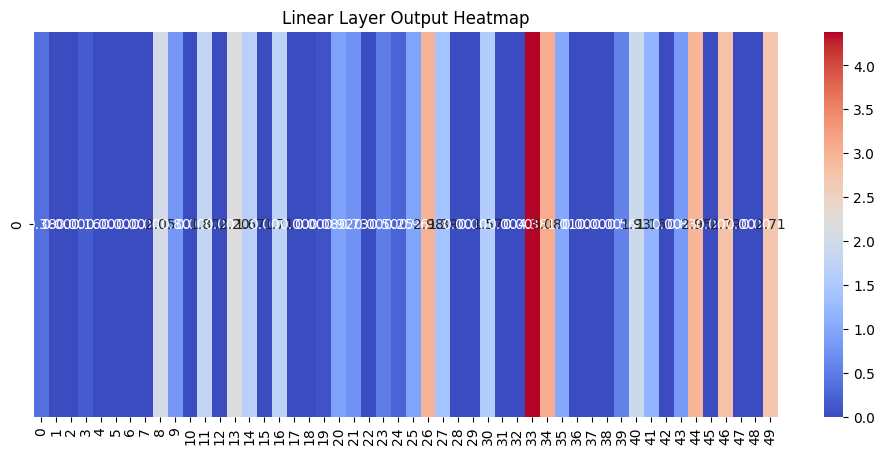

In [269]:
h_relu1.plot_out()

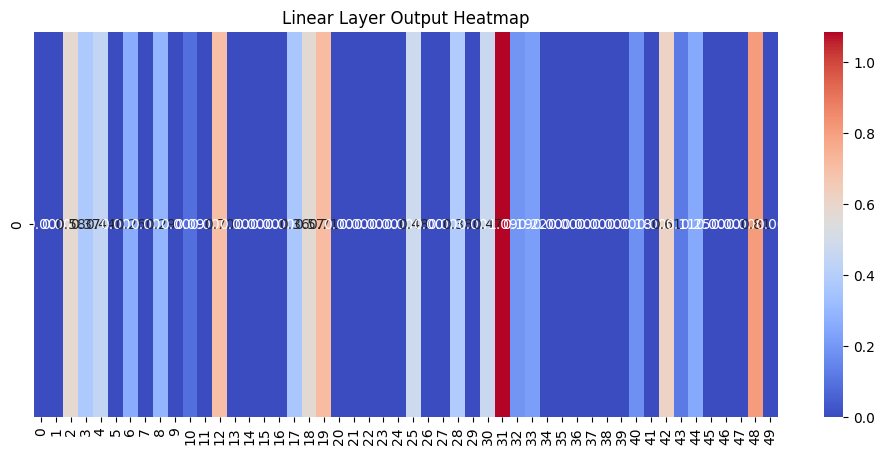

In [273]:
h_relu1.plot_out()

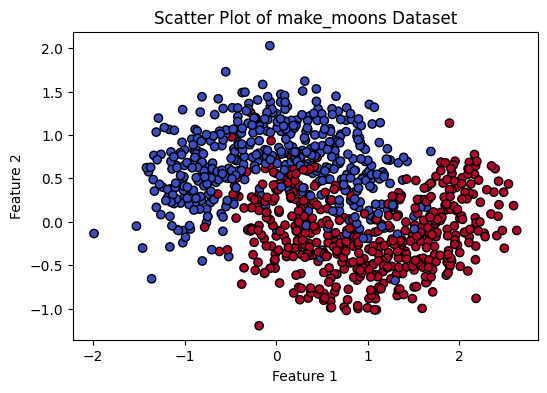

In [276]:
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=Y_, cmap="coolwarm", edgecolors="k")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of make_moons Dataset")
plt.show()

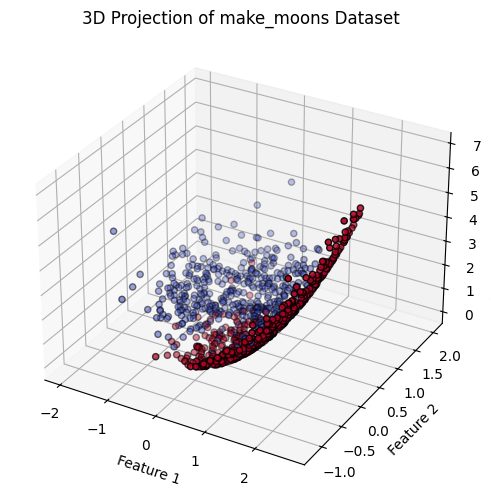

In [277]:
Z = X[:, 0]**2 + X[:, 1]**2  # Example nonlinear projection

# 3D Scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], Z, c=Y_, cmap="coolwarm", edgecolors="k")

# Labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Projected Feature 3 (Z)")
ax.set_title("3D Projection of make_moons Dataset")

plt.show()

In [52]:
net.layers[4]

In [66]:
out = net.forward(np.expand_dims(X[0],axis=0))

In [44]:
out

array([[0.76027288, 0.23972712]])

In [60]:
net.layers[0].parameter_var_mean(), net.layers[2].parameter_var_mean(), net.layers[4].parameter_var_mean()

((1.3213376642130306, 0.16073133530297407),
 (0.7542288377382512, -0.1373707364118314),
 (1.3461983158320598, -0.37051236858541725))

In [73]:
for idx,layer in enumerate(net.layers):
    if isinstance(layer,Linear):
        print(f"Linear {idx}")
        print(f"Weights Variance and Mean -> {layer.parameter_var_mean()}")
        print(f"Input Variance and Mean -> {layer.in_var_mean()}")
        print(f"Output Variance and Mean -> {layer.out_var_mean()}")
    if isinstance(layer,ReLU):
        print(f"Relu {idx}")
        print(f"Input Variance and Mean -> {layer.in_var_mean()}")
        print(f"Output Variance and Mean -> {layer.out_var_mean()}")

Linear 0
Weights Variance and Mean -> (0.37502900194011546, 1.069484513429205)
Input Variance and Mean -> (0.599473025681344, 0.368740106315949)
Output Variance and Mean -> (1.6215631048640236, 1.4473281544088643)
Relu 1
Input Variance and Mean -> (1.6215631048640236, 1.4473281544088643)
Output Variance and Mean -> (1.3516452667239163, 1.5099298158906982)
Linear 2
Weights Variance and Mean -> (0.8065509945893898, 0.21166442906773328)
Input Variance and Mean -> (1.3516452667239163, 1.5099298158906982)
Output Variance and Mean -> (5.094652641665528, 1.522265849186853)
Relu 3
Input Variance and Mean -> (5.094652641665528, 1.522265849186853)
Output Variance and Mean -> (4.023820522700096, 1.7464919794470002)
Linear 4
Weights Variance and Mean -> (0.8801493760375791, 0.4592201108106951)
Input Variance and Mean -> (4.023820522700096, 1.7464919794470002)
Output Variance and Mean -> (10.912839520873892, 3.909480232807431)


In [74]:
0.375029 * 0.599473

0.22481975971700002

In [75]:
0.37502900194011546 * 0.599473025681344

0.22481977051129565